In [3]:
import numpy as np

In [18]:
DEBUG = False

def debug_print(*args):
    if DEBUG:
        string = ''
        for arg in args:
            strarg = arg
            if type(arg) != type(''):
                strarg = str(arg)
            string += ' ' + strarg + ' '
        print(string)

class Dense:
    def __init__(self, in_size, out_size, act_fwd, act_bwd):
        self.W = np.random.rand(out_size, in_size)*0.1
        self.b = np.random.rand(out_size)*0.1#np.random.rand(in_size)*0.01
        self.act_fwd = act_fwd
        self.act_bwd = act_bwd
        
    def prop_fwd(self, A):
        self.A = A
        debug_print('A', self.A)
        debug_print('W', d2.W)
        self.Z = np.dot(self.W, A)+self.b 
        debug_print('Z', self.Z)
        return self.act_fwd(self.Z)
    
    def prop_bwd(self, dA, Z):
        return self.act_bwd(dA, Z)
        

In [63]:
def relu(Z):
    return np.maximum(0,Z)

def relu_grad(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_grad(dA, Z):
    sig = sigmoid(Z)
    return np.convolve(dA, sig * (1 - sig), 'same')#dA * sig * (1 - sig)

def tanh(Z):
    t=(np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    return t

def tanh_grad(dA, Z):
    t=tanh(Z)
    dt=1-t**2
    return dA * dt

def softmax(Z):
    eZ = np.exp(Z - np.max(Z))
    return eZ / eZ.sum(axis=0)

def softmax_grad(dA, Z):
    s = softmax(Z)
    s = Z.reshape(-1,1)
    jacobian = (np.diagflat(s) - np.dot(s, s.T))
    debug_print(dA.shape)
    debug_print(jacobian.shape)
    return np.matmul(dA, jacobian)

def binary_crossentropy_loss(Y_hat, Y): #binary cross entropy
    m = Y_hat.shape[0]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)
    
def binary_crossentropy_loss_grad(Y_hat, Y): #binary cross entropy
    eps = 1e-8
    return -(np.divide(Y, Y_hat+eps) - np.divide(1 - Y, 1 - Y_hat+eps))
    
def multi_cross_entropy(X,y):
    #TODO
    pass

def multi_cross_entropy_grad(X,y):
    #TODO
    pass

dA = np.array([[0.9, 0.1]])
y = np.array([0.1, 0.9])
#print(binary_crossentropy_loss_grad(y_hat, y))
print(softmax_grad(dA, y).shape, '\n')
print(softmax_grad(dA, y), '\n')

dA = np.array([[0.1, 0.9]])
y = np.array([0.9, 0.1])
#print(binary_crossentropy_loss_grad(y_hat, y))

print(softmax_grad(dA, y).shape)
print(softmax_grad(dA, y))

(1, 2) 

[[ 0.072 -0.072]] 

(1, 2)
[[-0.072  0.072]]


In [73]:
d1 = Dense(8,4,tanh, tanh_grad)
d2 = Dense(4,2,softmax, softmax_grad)
y = np.array([1.0, 0.0])
DEBUG=True
for i in range(7):
    debug_print('------FWD------')
    y_hat = 1-d2.prop_fwd(d1.prop_fwd(np.ones(8)))
    debug_print('Y_hat', y_hat)
    alpha = 1.0e-7
    
    debug_print('\n------BWD------')
    debug_print('D2')
    dA = binary_crossentropy_loss_grad(y_hat, y)
    debug_print('dA', dA)
    dZ = d2.prop_bwd(dA, d2.Z)
    debug_print('dZ', dZ)
    #dW = np.dot(dZ, d2.A.T)
    dW = np.array([np.array([np.sum(d2.A)*z]) for z in dZ])/d2.A.shape[0]
    debug_print('dW', dW)
    db = np.sum(dZ, axis=0, keepdims=True)/d2.A.shape[0]
    dA = np.dot(d2.W.T, dZ)
    debug_print('PRE', d2.W)
    d2.W -= dW#*alpha
    debug_print('POST', d2.W)
    d2.b -= db#*alpha
    
    debug_print('D1')
    debug_print('dA', dA)
    dZ = d1.prop_bwd(dA, d1.Z)
    #print(dZ.shape)
    debug_print('dZ', dZ)
    dW = np.array([np.array([np.sum(d1.A)*z]) for z in dZ])/d1.A.shape[0]
    debug_print('dW', dW)
    db = np.sum(dZ, axis=0, keepdims=True)/d1.A.shape[0]
    dA = np.dot(d1.W.T, dZ)
    debug_print('PRE', d1.W)
    d1.W -= dW*alpha
    debug_print('POST', d1.W)
    d1.b -= db*alpha
    #print(dW)
    
    
DEBUG=False

 ------FWD------ 
A [1. 1. 1. 1. 1. 1. 1. 1.]
W [[0.03088118 0.08681148 0.08129581 0.06164694]
 [0.05659027 0.07588227 0.05108127 0.06322843]]
Z [0.487278   0.57110299 0.34303881 0.41977536]
A [0.45205334 0.51616886 0.33018761 0.39674117]
W [[0.03088118 0.08681148 0.08129581 0.06164694]
 [0.05659027 0.07588227 0.05108127 0.06322843]]
Z [0.17282192 0.12406541]
 Y_hat  [0.48781329 0.51218671] 
 
------BWD------ 
 D2 
 dA  [-2.04996462  2.04996462] 
 (2,) 
 (2, 2) 
 dZ  [-0.33700542  0.26672993] 
 dW  [[-0.14281877]
 [ 0.11303687]] 
 PRE  [[0.03088118 0.08681148 0.08129581 0.06164694]
 [0.05659027 0.07588227 0.05108127 0.06322843]] 
 POST  [[ 0.17369995  0.22963025  0.22411458  0.20446571]
 [-0.05644661 -0.03715461 -0.06195561 -0.04980844]] 
 D1 
 dA  [ 0.00468719 -0.00901587 -0.01377223 -0.00391044] 
 dZ  [ 0.00372935 -0.00661377 -0.01227072 -0.00329492] 
 dW  [[ 0.00372935]
 [-0.00661377]
 [-0.01227072]
 [-0.00329492]] 
 PRE  [[0.08174018 0.03197887 0.00276576 0.05066532 0.08058919 0.09

/home/lorenz/miniconda3/envs/tquant/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/home/lorenz/miniconda3/envs/tquant/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


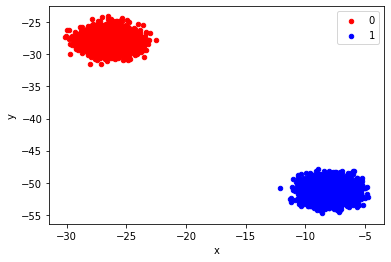

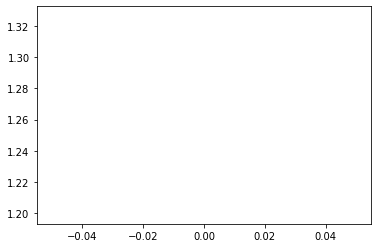

accuracy 1.0


In [144]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

num_classes = 2
num_features = 4


X, y = make_blobs(n_samples=10000, centers=num_classes, n_features=num_features, cluster_std=0.1, shuffle=True)
X*=10
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()
    
Y = np.zeros(shape = (len(y), num_classes))
for ind, label in enumerate(y):
    Y[ind][label] = 1.0

#X = (X-X.min())/(X.max()-X.min())

layers = [
    Dense(4,2, tanh, tanh_grad),
    Dense(2, 2, softmax, softmax_grad)]

epochs = 1
alpha = 1.0e-3
iteration_loss = []
epoch_loss = []
DEBUG=False
for i  in range(epochs):
    #alpha *=1/2
    for j, sample in enumerate(X):
        intermediate = sample
        for layer in layers:
            intermediate = layer.prop_fwd(intermediate)
        Y_hat = 1 - intermediate
        iteration_loss.append(binary_crossentropy_loss(Y_hat, Y[j]))
        
        dA = binary_crossentropy_loss_grad(Y_hat, Y[j])
        layers.reverse()
        updW = []
        updB = []
        for k, layer in enumerate(layers):
            dZ = layer.prop_bwd(dA, layer.Z)
            dW = np.array([np.array([np.sum(layer.A)*z]) for z in dZ])/layer.A.shape[0]
            db = np.sum(dZ, axis=0, keepdims=True)/layer.A.shape[0]
            dA = np.dot(layer.W.T, dZ)
            updW.append(dW*alpha)
            updB.append(db*alpha)
        
        for k, W in enumerate(updW):
            layers[k].W -= W
            layers[k].b -= updB[k]
            
        layers.reverse()
    epoch_loss.append(np.array(iteration_loss).mean())
        
        
correct = 0
pyplot.plot(epoch_loss)
pyplot.show()
for j, x in enumerate(X):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
        #print(Y_hat)
    
    DEBUG=True
    #debug_print('NN:', np.around(Y_hat, decimals=5), 'LABEL:',Y[j])
    DEBUG=False
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1
print('accuracy', correct/len(y))

In [145]:
for j, x in enumerate(X):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
        #print(Y_hat)
    
    DEBUG=True
    debug_print('NN:', np.around(Y_hat, decimals=5), 'LABEL:',Y[j])
    DEBUG=False
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1
print('accuracy', correct/len(y))

 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72457 0.27543]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.72478 0.27522]  LABEL:  [1. 0.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72433 0.27567]  LABEL:  [1. 0.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72436 0.27564]  LABEL:  [1. 0.] 
 NN:  [0.72434 0.27566]  LABEL:  [1. 0.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0

 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.72477 0.27523]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  [0.72448 0.27552]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  

 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72457 0.27543]  LABEL:  [1. 0.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72462 0.27538]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72478 0.27522]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72451 0.27549]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0

 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.72446 0.27554]  LABEL:  [1. 0.] 
 NN:  [0.7246 0.2754]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.72422 0.27578]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.26222 0.73778]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.72439

 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72444 0.27556]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.724

 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.72479 0.27521]  LABEL:  [1. 0.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.72449 0.27551]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72451 0.27549]  LABEL:  [1. 0.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.262

 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.72433 0.27567]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72452 0.27548]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72457 0.27543]  LABEL:  [1. 0.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.7246 0.2754]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72426 0.27574]  LABEL:  [1. 0.] 
 NN:  [0.724

 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72478 0.27522]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72462 0.27538]  LABEL:  [1. 0.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.72477 0.27523]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2

 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72477 0.27523]  LABEL:  [1. 0.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.72447 0.27553]  LABEL:  [1. 0.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.72445 0.27555]  LABEL:  [1. 0.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 


 NN:  [0.26222 0.73778]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72436 0.27564]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.72449 0.27551]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72456 0.27544]  LABEL:  [1. 0.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72439 0.27561]  LABEL:  [1. 0.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.7

 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72462 0.27538]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72449 0.27551]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72478 0.27522]  LABEL:  [1. 0.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.262

 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.72451 0.27549]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.7248 0.2752]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.72448 0.27552]  LABEL:  [1. 0.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26222 0.73778]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.

 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.26222 0.73778]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72457 0.27543]  LABEL:  [1. 0.] 
 NN:  [0.7244 0.2756]  LABEL:  [1. 0.] 
 NN:  [0.72438 0.27562]  LABEL:  [1. 0.] 
 NN:  [0.72451 0.27549]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72448 0.27552]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  

 NN:  [0.72471 0.27529]  LABEL:  [1. 0.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.72438 0.27562]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.72462 0.27538]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  

 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.7245 0.2755]  LABEL:  [1. 0.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72472 0.27528]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72452 0.27548]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.72445 0.27555]  LABEL:  [1. 0.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.72455 0.27545]  LABEL:  [1. 0.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.7

 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.72474 0.27526]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.72452 0.27548]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.7246 0.2754]  LABEL:  [1. 0.] 
 NN:  [0.7248 0.2752]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72459 0.27541]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 

 NN:  [0.72454 0.27546]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.7246 0.2754]  LABEL:  [1. 0.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.7247 0.2753]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72445 0.27555]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72449 0.27551]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.72453 0.27547]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2

 NN:  [0.72461 0.27539]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72469 0.27531]  LABEL:  [1. 0.] 
 NN:  [0.72466 0.27534]  LABEL:  [1. 0.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72425 0.27575]  LABEL:  [1. 0.] 
 NN:  [0.72444 0.27556]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72479 0.27521]  LABEL:  [1. 0.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.72476 0.27524]  LABEL:  [1. 0.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26222 0.73778]  LABEL:  [0. 1.] 
 NN:  [0.72464 0.27536]  LABEL:  [1. 0.] 
 NN:  [0.72462 0.27538]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2

 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72468 0.27532]  LABEL:  [1. 0.] 
 NN:  [0.72473 0.27527]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.72465 0.27535]  LABEL:  [1. 0.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72463 0.27537]  LABEL:  [1. 0.] 
 NN:  [0.72467 0.27533]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.26221 0.73779]  LABEL:  [0. 1.] 
 NN:  [0.72475 0.27525]  LABEL:  [1. 0.] 
 NN:  [0.72458 0.27542]  LABEL:  [1. 0.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2622 0.7378]  LABEL:  [0. 1.] 
 NN:  [0.2